In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import zipfile
import shutil
import warnings
from typing import List
from typing import Tuple
from CNN_helper_function import get_labels, eval_model
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip,RandomCrop

from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import load_model

seed = 42
tf.random.set_seed(seed)

2025-02-02 11:51:44.141024: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-02 11:51:44.196192: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-02 11:51:44.196225: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-02 11:51:44.197439: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 11:51:44.204372: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2025-02-02 11:51:47.961519: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-02 11:51:48.016342: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-02 11:51:48.016583: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# 1. Data Augmentation

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img, save_img
# Function to generate 5 crops and their horizontal flips
def augment_image(image):
    crops = []

    # Original image shape should be (256, 256, 3)
    height, width = image.shape[:2]

    # Define the coordinates for the 5 crops
    top_left = image[:224, :224]
    top_right = image[:224, width-224:]
    bottom_left = image[height-224:, :224]
    bottom_right = image[height-224:, width-224:]
    center = image[(height-224)//2:(height+224)//2, (width-224)//2:(width+224)//2]

    # Collect the crops
    crops.extend([top_left, top_right, bottom_left, bottom_right, center])

    # Generate horizontal flips for each crop
    flipped_crops = [np.fliplr(crop) for crop in crops]

    # Combine original crops with flipped crops
    all_crops = crops + flipped_crops

    return all_crops

In [7]:
# # Directories for saving augmented images
# save_dir = '/teamspace/studios/this_studio/EFlow Images/AlexNet_augmentation'
# os.makedirs(save_dir, exist_ok=True)
# os.makedirs(os.path.join(save_dir,'background'), exist_ok=True) #background directory
# os.makedirs(os.path.join(save_dir,'signal'), exist_ok=True) #signal directory

In [10]:
# print(f'Current Working Directory: {os.getcwd()}')
# data_dir = '/teamspace/studios/this_studio/EFlow Images/data'

# for directory in os.listdir(data_dir):
#     print(f"Inside {directory}")
#     img_count = 0
#     for i, image_path in enumerate(os.listdir(os.path.join(data_dir,directory))):
#         image_path = os.path.join(data_dir,directory, image_path)
#         img = load_img(image_path)
#         img = img_to_array(img)

#         if i%500 == 0:
#             print(f'Loaded {i}th image succesfully...')

#         #Resize to 256x256 if necessary
#         img = tf.image.resize(img, [256, 256]).numpy()
    
#         # Generate 10 augmented images
#         augmented_images = augment_image(img)
    
#         # Save each augmented image with the corresponding label
#         for j, augmented_image in enumerate(augmented_images):
#             # Convert to PIL image
#             augmented_image = array_to_img(augmented_image)

#             save_image_name = f'{os.path.basename(image_path).split("/")[-1].split(".")[0]}_aug_{j}.png'
#             dest_path = os.path.join(save_dir, directory)
    
#             # Save the image
#             #augmented_image.save(dest_path, "PNG")
#             augmented_image.save(os.path.join(dest_path, save_image_name))

        
#         img_count +=1
        
#     print(f'Images processed inside {directory}: {img_count}')
# print('------Task Completed------')

Current Working Directory: /teamspace/studios/this_studio/EFlow Images/Notebooks
Inside background
Loaded 0th image succesfully...
Loaded 500th image succesfully...
Loaded 1000th image succesfully...
Loaded 1500th image succesfully...
Loaded 2000th image succesfully...
Loaded 2500th image succesfully...
Loaded 3000th image succesfully...
Loaded 3500th image succesfully...
Loaded 4000th image succesfully...
Loaded 4500th image succesfully...
Loaded 5000th image succesfully...
Loaded 5500th image succesfully...
Loaded 6000th image succesfully...
Loaded 6500th image succesfully...
Loaded 7000th image succesfully...
Loaded 7500th image succesfully...
Loaded 8000th image succesfully...
Loaded 8500th image succesfully...
Loaded 9000th image succesfully...
Loaded 9500th image succesfully...
Images processed inside background: 9847
Inside signal
Loaded 0th image succesfully...
Loaded 500th image succesfully...
Loaded 1000th image succesfully...
Loaded 1500th image succesfully...
Loaded 2000th 

# 2. Loading the Dataset

Found 196750 files belonging to 2 classes.


2025-02-02 11:53:14.955825: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-02 11:53:14.956143: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-02 11:53:14.956302: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

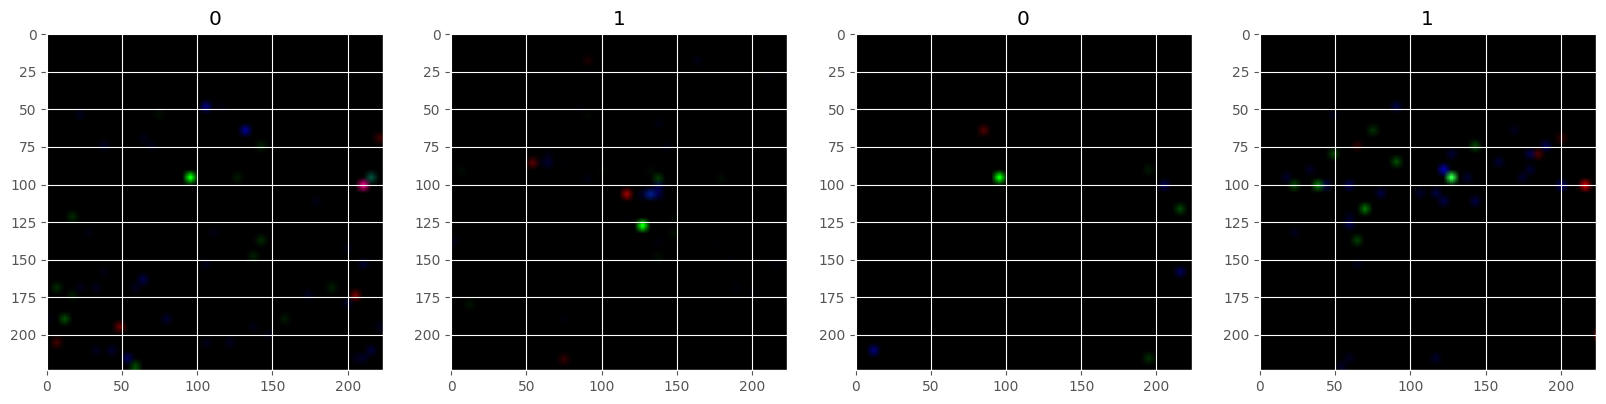

In [5]:
data_dir = '/teamspace/studios/this_studio/all/EFlow Images/AlexNet/AlexNet_augmentation'

data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                   seed=seed,
                                                   batch_size = 70,
                                                   image_size = (224,224))

data = data.map(lambda x, y: (x/255, y))

data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

## 2.1 Train-Test Split

In [6]:
train_size = int(len(data)*.7) #70% of total batches as training data
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 3. AlexNet Architecture

In [7]:
alex_net = Sequential()

alex_net.add(Conv2D(96, (11,11), 4, activation='relu', input_shape=(224,224,3)))
alex_net.add(MaxPooling2D((3,3), strides = 2))

alex_net.add(Conv2D(256, (5,5), strides = 1, activation='relu', padding = 'same'))
alex_net.add(MaxPooling2D((3,3), strides = 2))

alex_net.add(Conv2D(384, (3,3), 1, activation='relu', padding = 'same'))
alex_net.add(Conv2D(384, (3,3), 1, activation='relu', padding = 'same'))
alex_net.add(Conv2D(256, (3,3), 1, activation='relu', padding = 'same'))
alex_net.add(MaxPooling2D((3,3), strides = 2))

alex_net.add(Flatten())
alex_net.add(Dropout(0.5))
alex_net.add(Dense(4096, activation = 'relu'))
alex_net.add(Dropout(0.5))
alex_net.add(Dense(4096, activation = 'relu'))

#Output Layer
alex_net.add(Dense(1, activation = 'sigmoid'))

alex_net.summary()

#(W-2F+P/S) +1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 384)       1

# 4. Training the Model

In [8]:
alex_net.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()])

In [9]:
logdir = '/teamspace/studios/this_studio/all/EFlow Images/model_tensorboard_logs/alex_net_logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

checkpoint_callback = ModelCheckpoint(
    filepath='EFlow Images/alex_netClassifier.keras',
    save_weights_only=False,
    monitor='val_accuracy',              
    mode='auto',           
    save_best_only=True,
    verbose=2
)

In [10]:
alex_net_hist = alex_net.fit(train,
                 epochs = 10,
                 validation_data = val, 
                 callbacks = [tensorboard_callback])

Epoch 1/10


2025-02-02 11:54:22.404792: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900
2025-02-02 11:54:26.545020: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe38dc90b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-02 11:54:26.545055: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-02-02 11:54:26.551116: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738497266.674387   44087 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1538/1967 [======================>.......] - ETA: 27s - loss: 0.6941 - accuracy: 0.5010 - precision: 0.5016 - recall: 0.5391 - auc: 0.5030 - true_positives: 29067.0000 - false_positives: 28879.0000 - true_negatives: 24867.0000 - false_negatives: 24847.0000

KeyboardInterrupt: 

# 5. Testing

In [17]:
eval_metrices = alex_net.evaluate(test)

281/281 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - accuracy: 0.8236 - auc_2: 0.9053 - false_negatives_2: 887.6595 - false_positives_2: 859.4787 - loss: 0.3985 - precision_2: 0.8257 - recall_2: 0.8187 - true_negatives_2: 4118.3936 - true_positives_2: 4039.2200


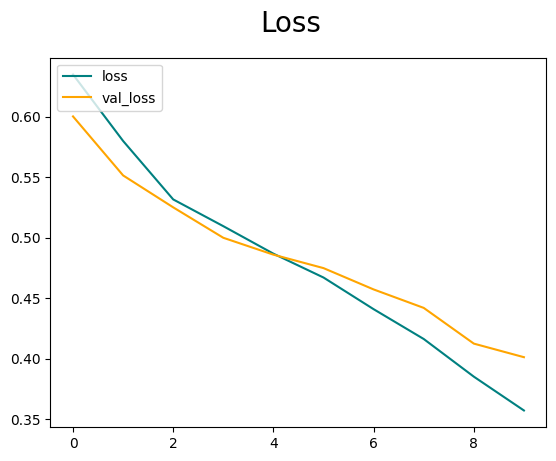

In [18]:
fig, axs = plt.subplots(1, 3, figsize = (13,4))

# Loss Plot
axs[0].plot(alex_net_hist.history['loss'], color='teal', label='loss')
axs[0].plot(alex_net_hist.history['val_loss'], color='orange', label='val_loss')
axs[0].set_xlabel('Epochs')
axs[0].set_title('Loss')
axs[0].legend(loc="upper left")

# Accuracy Plot
axs[1].plot(alex_net_hist.history['accuracy'], color='teal', label='accuracy')
axs[1].plot(alex_net_hist.history['val_accuracy'], color='orange', label='val_accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_title('Accuracy')
axs[1].legend(loc="upper left")

# AUC Plot
axs[2].plot(alex_net_hist.history['auc'], color='teal', label='auc')
axs[2].plot(alex_net_hist.history['val_auc'], color='orange', label='val_auc')
axs[2].set_xlabel('Epochs')
axs[2].set_title('AUC')
axs[2].legend(loc="upper left")

plt.suptitle("Model's Loss, Accuracy, AUC vs Epochs", fontsize = 20, fontweight = 'bold')
plt.tight_layout()
# plt.savefig('CNNClassifier_model1_trainingMetrics.png', dpi = 300)
plt.show()

# 6. Predictions

In [24]:
y_pred = alex_net.predict(test)

281/281 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step


In [25]:
test_data_list = list(test)
labels = []
for batch in test_data_list:
    images, label = batch
    # Process your batch here
    labels.append(label.numpy())
    #print(images.shape, labels.shape)
y_true = np.concatenate(labels, axis=0)

2024-08-12 10:42:37.469993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [42]:
#To save the numpy arrays
#np.save('EFlow Images/Notebooks', y_true)

# 7. ROC Curve

In [12]:
y_pred = np.load('/teamspace/studios/this_studio/EFlow Images/AlexNet/y_pred.npy')
y_true = np.load('/teamspace/studios/this_studio/EFlow Images/AlexNet/y_true.npy')

In [13]:
thresh = np.arange(0.0, 1.01, 0.2)

In [14]:
def roc(y_true:List, y_pred:List, thresholds:List) -> Tuple:
    FPR = []
    TPR = []
    P = sum(y_true) #Number of Positives labels
    N = len(y_true) - P #Number of Negative Labels

    for thresh in thresholds:
        FP = 0
        TP = 0
        thresh = round(thresh,2)
        for i in range(len(y_pred)):
            if (y_pred[i] >= thresh):
                if y_true[i] == 1:
                    TP += 1
                if y_true[i] == 0:
                    FP += 1
        FPR.append(FP/N)
        TPR.append(TP/P)
    AUC = -1 * np.trapz(TPR, FPR)

    return (FPR, TPR, AUC)

def plotROC_curve(FPR, TPR, AUC):
    plt.plot(FPR, TPR, linestyle='--', marker='o', color='darkorange', lw = 2, label='ROC curve', clip_on=False)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve, AUC = %.2f'%AUC)
    plt.legend(loc="lower right")
    plt.show()

In [15]:
FPR, TPR, AUC = roc(y_true, y_pred, thresh)

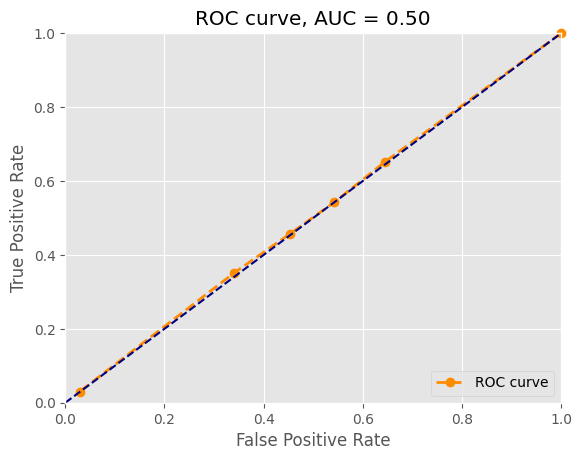

In [16]:
plotROC_curve(FPR, TPR, AUC)

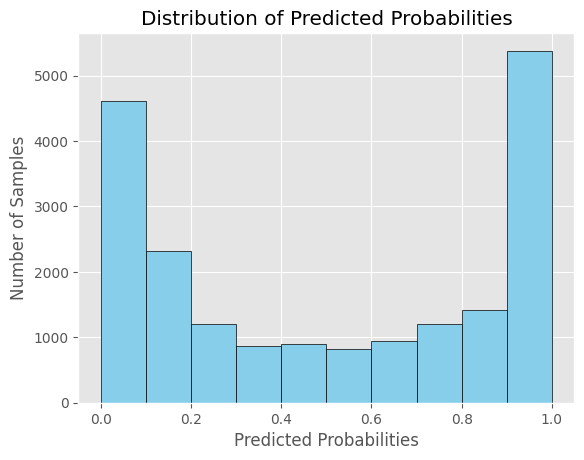

In [25]:
plt.title('Distribution of Predicted Probabilities')
plt.hist(y_pred, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Number of Samples')
plt.show()

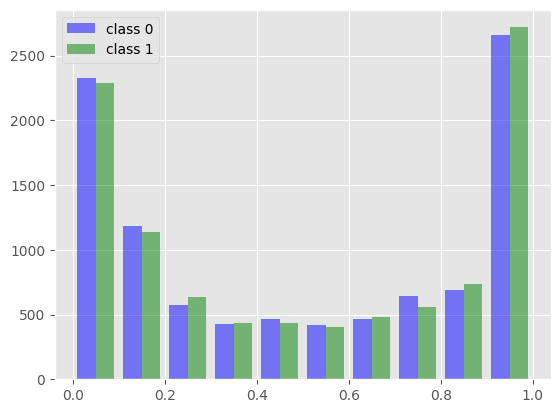

In [27]:
plt.hist([y_pred[y_true == 0], y_pred[y_true == 1]], bins=10, color=['blue', 'green'], label=['class 0', 'class 1'], alpha=0.5)
plt.legend()
plt.show()

In [17]:
org_y_pred = np.load('/teamspace/studios/this_studio/EFlow Images/AlexNet/original_y_pred_complete.npy')
org_y_true = np.load('/teamspace/studios/this_studio/EFlow Images/AlexNet/original_y_true_complete.npy')

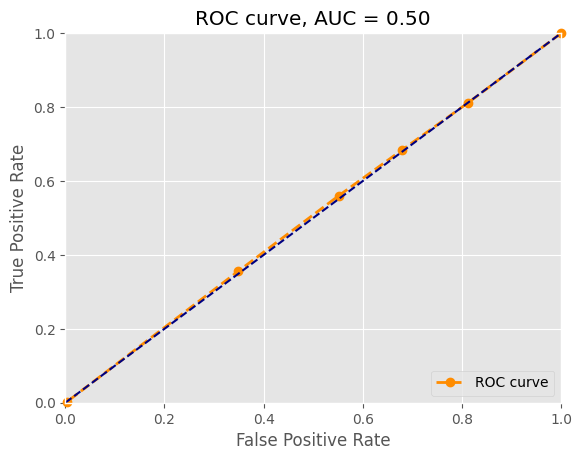

In [18]:
org_FPR, org_TPR, org_AUC = roc(org_y_true, org_y_pred, thresh)
plotROC_curve(org_FPR, org_TPR, org_AUC)

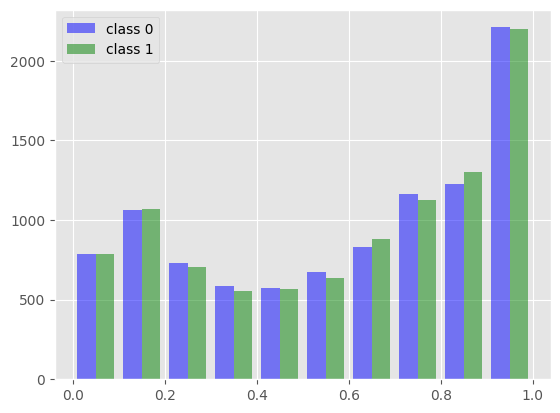

In [10]:
plt.hist([org_y_pred[org_y_true == 0], org_y_pred[org_y_true == 1]], bins=10, color=['blue', 'green'], label=['class 0', 'class 1'], alpha=0.5)
plt.legend()
plt.show()